# Urban Accessibility — How close is my nearest Żabka ?

## 0. Motivation / Project idea

This project leans heavily on the methodologies used by [Milan Janosov](https://medium.com/@janosovm) in his article [Urban Accessibility — How to Reach Defibrillators on Time](https://towardsdatascience.com/urban-accessibility-how-to-reach-defibrillators-on-time-c865d9194448). His articles are a true inspiration. 

I strongly recommend giving him a follow on [Patreon](https://patreon.com/milanjanosov?utm_medium=clipboard_copy&utm_source=copyLink&utm_campaign=creatorshare_fan&utm_content=join_link).

On arrival in Kraków one of the first things to grab my attention was the number of Żabka convenience stores. Those little green frogs seem to be everywhere!

I thought it would be fun to perform a geospatial analysis of the accessibility of these stores. For comparison purposes I chose to also look at Poznań. 

## 1. Packages

The project harnesses a number of Python libraries. I was familiar with most of these but this was my first look at Uber's [H3: Uber’s Hexagonal Hierarchical Spatial Index](https://www.uber.com/en-HU/blog/h3/). I can't stop seeing hexagons now!!!


- [pandas](https://pandas.pydata.org/)
- [NumPy](https://numpy.org/)
- [OSMnx](https://osmnx.readthedocs.io/en/stable/)
- [matplotlib](https://matplotlib.org/)
- [pandana](https://udst.github.io/pandana/)
- [geopandas](https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html)
- [shapely](https://shapely.readthedocs.io/en/stable/manual.html)
- [h3](https://h3geo.org/)
- [rioxarray](https://corteva.github.io/rioxarray/stable/)
- [Xarray](https://docs.xarray.dev/en/stable/)
- [Datashader](https://datashader.org/)

### 1.1 Administrative boundaries

First up, we leverage [OSMnx](https://osmnx.readthedocs.io/en/stable/) to very quickly grab the administrative boundaries of Kraków and Poznań :

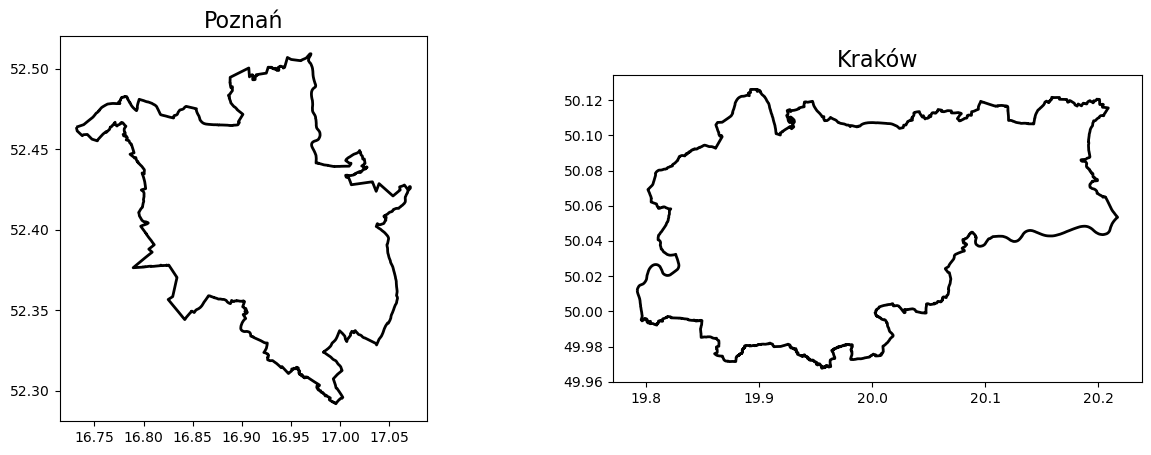

In [1]:
import osmnx as ox # version: 1.0.1
import matplotlib.pyplot as plt # version: 3.7.1

admin  = {}
cities = ['Poznań', 'Kraków']
f, ax  = plt.subplots(1,2, figsize = (15,5))

# visualize the admin boundaries
for idx, city in enumerate(cities):
    admin[city] = ox.geocode_to_gdf(city)
    admin[city].plot(ax=ax[idx],color='none',edgecolor= 'k', linewidth = 2), ax[idx].set_title(city, fontsize = 16)

### 1.2. Population data

We can create population grids in vector data format for both cities, building on this fine-grained population estimate data source which can be downloaded as a `.tif` file via [WorldPop Hub](https://hub.worldpop.org/geodata/summary?id=49862) using the constrained individual countries data set at a resolution of 100m curated in 2020.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import rioxarray
# rioxarray 0.13.4
import xarray as xr # 2022.3.0
import datashader as ds  # version: 0.15.2
import pandas as pd
import numpy as np
from colorcet import palette
from datashader import transfer_functions as tf

We can work with `.tif` files using [rioxarray](https://corteva.github.io/rioxarray/stable/) :  

In [4]:
# # parse the data
poland_file  = "pol_ppp_2020_constrained.tif" 
poland_array = rioxarray.open_rasterio(poland_file, chunks=True, lock=False)
poland_array

<xarray.DataArray (band: 1, y: 6996, x: 12038)>
dask.array<open_rasterio-3023a6f2c25549830c7402d27ce282c8<this-array>, shape=(1, 6996, 12038), dtype=float32, chunksize=(1, 2787, 12038), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 14.12 14.12 14.12 14.12 ... 24.15 24.15 24.15 24.15
  * y            (y) float64 54.84 54.83 54.83 54.83 ... 49.01 49.01 49.01 49.01
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  177.73922499704
    STATISTICS_MEAN:     1.9344332425513
    STATISTICS_MINIMUM:  0.0074601334268273
    STATISTICS_STDDEV:   4.2127535208917
    _FillValue:          -99999.0
    scale_factor:        1.0
    add_offset:          0.0

And quickly visualize the population of Poland from this raster file using Matplotlib. 

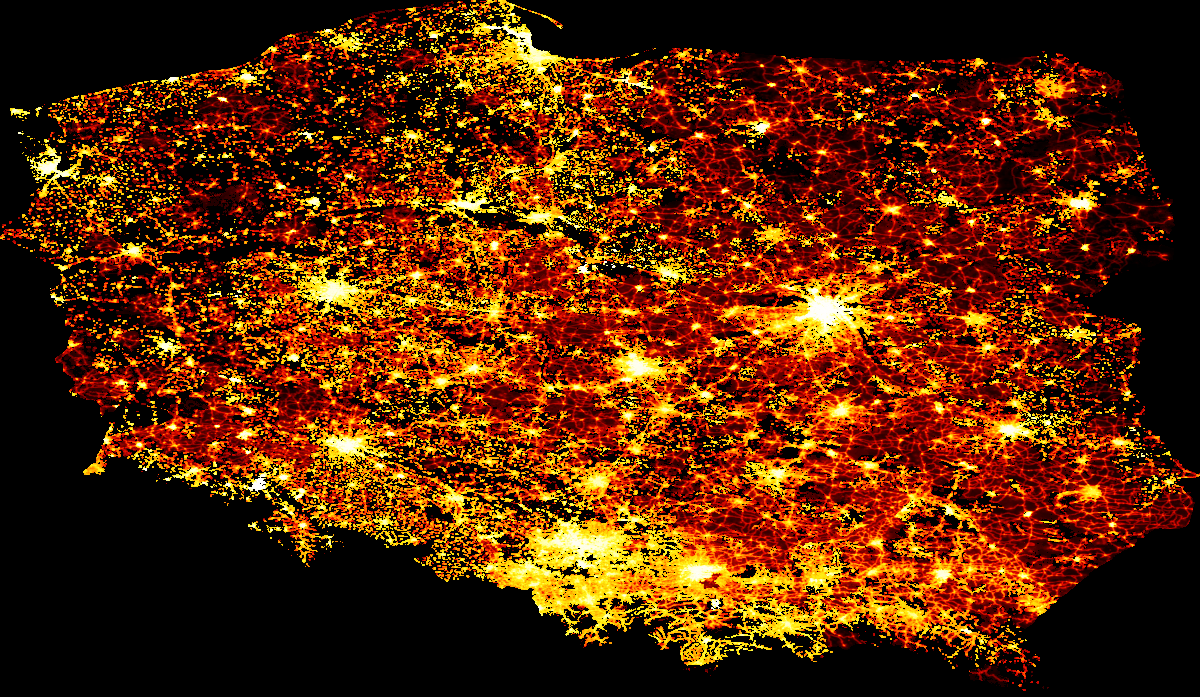

In [5]:
# prepare the data
poland_array = xr.DataArray(poland_array)[0]
poland_array = poland_array.where(poland_array > 0)
poland_array = poland_array.compute()
poland_array = np.flip(poland_array, 0)


# get the image size
size = 1200
asp  = poland_array.shape[0] / poland_array.shape[1]

# create the data shader canvas
cvs = ds.Canvas(plot_width=size, plot_height=int(asp*size))
raster = cvs.raster(poland_array)

# draw the image
cmap = palette["fire"]
img = tf.shade(raster, how="eq_hist", cmap=cmap)
img = tf.set_background(img, "black")
img

We can clearly see the populous cities of (from west to east) Szczecin, Poznań, Wrocław, Gdańsk, Katowice, Łódź, Kraków and Warsaw.

Now that we have visualized Poland let's look at things at a city level and show you how to transform such raster data into vector format and manipulate it easily with GeoPandas. For this, I access the administrative boundaries of Kraków in a geojson format [here](https://github.com/dchoruzy/poland-geojson/blob/master/cities/high-quality/krakow/krakow.geojson). This file contains the boroughs of Kraków, so first, we need to merge them into the city as a whole :

<AxesSubplot: >

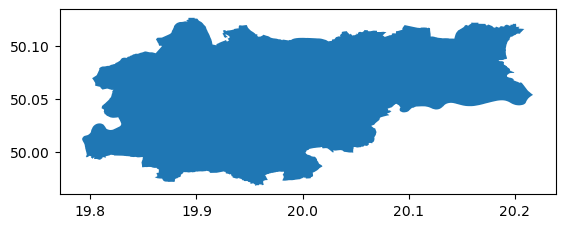

In [6]:
from shapely.ops import cascaded_union
import geopandas as gpd

# Read the GeoJSON file
krakow = gpd.read_file('krakow.geojson')

# Perform cascaded union on the geometries and create a new GeoDataFrame
krakow = cascaded_union(krakow['geometry'])
krakow = gpd.GeoDataFrame(geometry=[krakow])

# Plot the resulting GeoDataFrame
krakow.plot()

Now we can turn the xarray into a Pandas DataFrame, extract the geometry information, and build a GeoPandas GeoDataFrame. One way to do this:

In [7]:
import pandas as pd # version: 1.4.2
from shapely.geometry import Point

df_poland = pd.DataFrame(poland_array.to_series(), columns = ['population']).dropna()
df_poland

population
y         x                    
49.060000 22.685000    0.479311
          22.685833    0.478492
          22.686667    0.481470
          22.687500    0.479595
          22.688333    0.475236
...                         ...
54.834167 18.323333    3.238961
          18.324167    3.084985
          18.325000    2.966888
          18.325833    2.802020
54.835833 18.290000    2.172088

[20286799 rows x 1 columns]

Now build a GeoDataFrame from this, focusing on Krakow :

In [8]:
# find the limiting bounding box for easier coodinate-selection
minx, miny, maxx, maxy = krakow.bounds.T[0].to_list()

points = []
population = df_poland.population.to_list()
indices = list(df_poland.index)

In [10]:
# create Point geometries from the points falling into this bounding box
geodata = []
for ijk, (lon, lat) in enumerate(indices):
    if minx <= lat <= maxx and miny <= lon <= maxy:   
        geodata.append({'geometry' : Point(lat, lon), 'population' : population[ijk]})
        
len(geodata)

80807

In [12]:
# build a GeoDataFrame
gdf_krakow = gpd.GeoDataFrame(geodata)
gdf_krakow = gpd.overlay(gdf_krakow, krakow)
gdf_krakow.head()

population                   geometry
0    7.174075  POINT (19.95583 49.96833)
1    7.512988  POINT (19.95500 49.96917)
2    6.941103  POINT (19.95583 49.96917)
3    6.333723  POINT (19.95667 49.96917)
4    6.613466  POINT (19.95750 49.96917)

Then, visualize the population as vector data:  

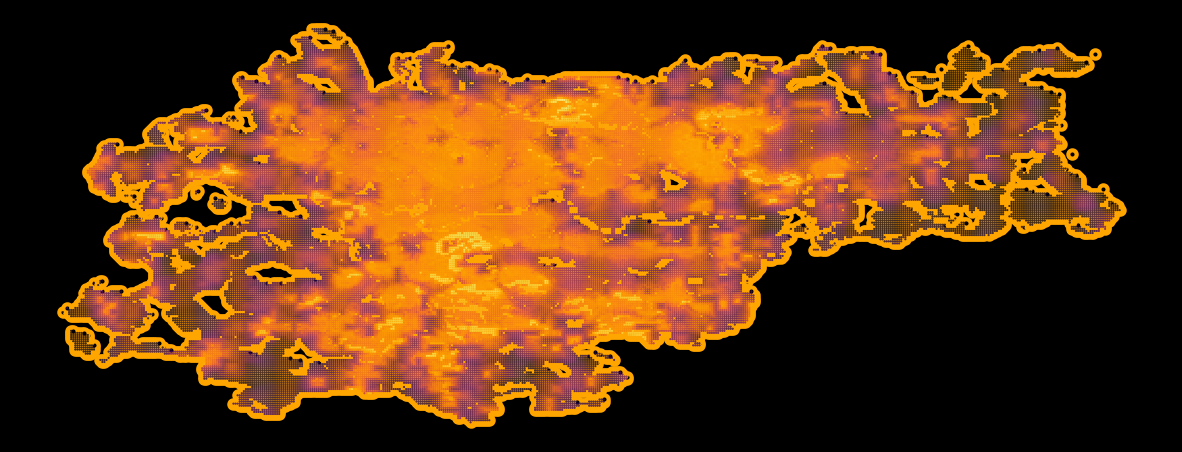

In [13]:
import matplotlib.pyplot as plt # version: 3.7.1

f, ax = plt.subplots(1,1,figsize=(15,15))
gdf_krakow.plot(ax=ax, color = 'k', edgecolor = 'orange', linewidth = 3)
gdf_krakow.plot(column = 'population', cmap = 'inferno', ax=ax, alpha = 0.9, markersize = 0.25)
ax.axis('off')
f.patch.set_facecolor('black')

In [14]:
type(gdf_krakow)

geopandas.geodataframe.GeoDataFrame

In [19]:
# Specify the output file path and name
output_file = 'kraków_population_grid.geojson'

# Save the GeoDataFrame as a GeoJSON file
gdf_krakow.to_file(output_file, driver='GeoJSON')

I performed the same steps for Poznan.

We can make things look nice by creating a custom colormap from the color of 2022, Very Peri.

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

very_peri = '#8C6BF3'  
second_color = '#6BAB55'   

colors = [second_color, very_peri]
n_bins = 100
cmap_name = "VeryPeri"
colormap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

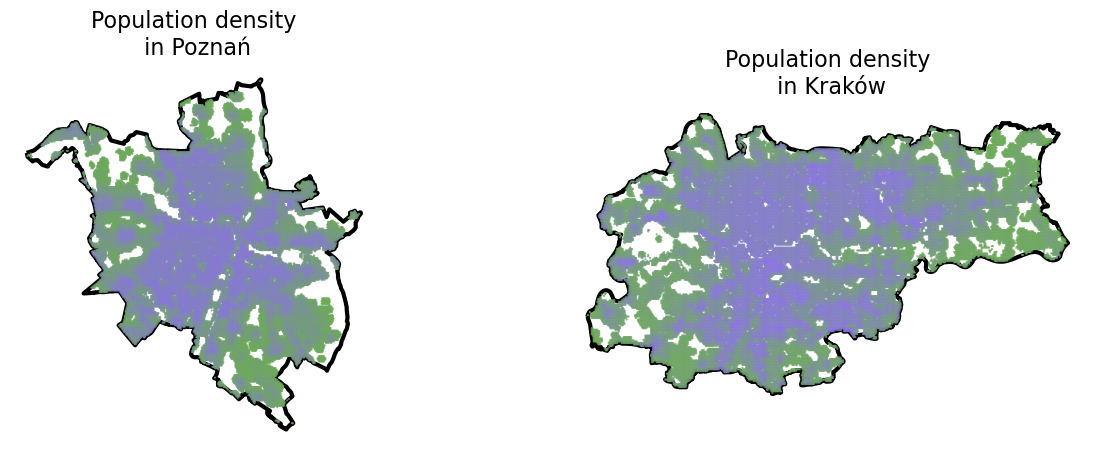

In [20]:
import geopandas as gpd # version: 0.9.0

demographics = {}
f, ax = plt.subplots(1,2, figsize = (15,5))

for idx, city in enumerate(cities):
    demographics[city] = gpd.read_file(city.lower() + \
      '_population_grid.geojson')[['population', 'geometry']]
    admin[city].plot(ax=ax[idx], color = 'none', edgecolor = 'k', \
      linewidth = 3)
    demographics[city].plot(column = 'population', cmap = colormap, \
      ax=ax[idx], alpha = 0.9, markersize = 0.25)
    ax[idx].set_title(city)
    ax[idx].set_title('Population density\n in ' + city, fontsize = 16)
    ax[idx].axis('off')

### 1.3. Żabka locations 

I will now demonstrate how you can harvest points of interest from Open Street Maps.

#### Kraków

In [21]:
import osmnx as ox
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
city = 'Kraków'

In [23]:
krakow_gdf = ox.geocode_to_gdf(city)
krakow_gdf

geometry  bbox_north  bbox_south  \
0  POLYGON ((19.79224 50.01180, 19.79238 50.01104...   50.126134   49.967667   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat        lon  \
0  20.217346  19.792236  191790546  relation  449696  50.061947  19.936856   

      class            type  place_rank  importance addresstype    name  \
0  boundary  administrative          12     0.69366        city  Krakow   

                                display_name  
0  Krakow, Lesser Poland Voivodeship, Poland

In [24]:
shops_krakow = ox.geometries_from_place(
    city,
    tags ={'shop': True}    
)

In [25]:
len(shops_krakow)

5801

In [26]:
shops_krakow.columns

Index(['name', 'shop', 'geometry', 'amenity', 'brand', 'brand:wikidata',
       'fuel:GTL_diesel', 'fuel:HGV_diesel', 'fuel:lpg', 'fuel:octane_95',
       ...
       'flower_pot:plastic', 'toilets:access', 'toilets:fee',
       'service:vehicle:painting', 'pastry', 'name:bg', 'room', 'industrial',
       'construction', 'ways'],
      dtype='object', length=366)

In [29]:
shops_krakow

name           shop  \
element_type osmid                                            
node         258234549               O! Shop    convenience   
             277718808          BP Krakowiak    convenience   
             287595866         O! Shop Orlen    convenience   
             472011595                   NaN  travel_agency   
             472407933       Lewiatan Market    convenience   
...                                      ...            ...   
way          1217141351                  NaN         vacant   
             1217141352                  NaN         vacant   
             1217141353  Kwiaciarnia "Eliza"        florist   
             1217141357          Pierogarnia    frozen_food   
relation     2580586                     NaN           mall   

                                                                  geometry  \
element_type osmid                                                           
node         258234549                           POINT (19.91015 50.07478)   
             277718808                           POINT (19.98509 50.08704)   
             287595866                           POINT (20.00985 50.01074)   
             472011595                           POINT (19.94485 50.06545)   
             472407933                           POINT (19.96831 50.08802)   
...                                                                    ...   
way          1217141351  POLYGON ((19.92802 50.08418, 19.92794 50.08418...   
             1217141352  POLYGON ((19.92785 50.08420, 19.92793 50.08420...   
             1217141353  POLYGON ((19.92780 50.08422, 19.92785 50.08422...   
             1217141357  POLYGON ((19.92823 50.08419, 19.92832 50.08419...   
relation     2580586     POLYGON ((19.92803 50.09446, 19.92818 50.09403...   

                        amenity      brand brand:wikidata fuel:GTL_diesel  \
element_type osmid                                                          
node         258234549      NaN        NaN            NaN             NaN   
             277718808     fuel         BP        Q152057             yes   
             287595866      NaN  PKN Orlen            NaN             NaN   
             472011595      NaN        NaN            NaN             NaN   
             472407933      NaN        NaN            NaN             NaN   
...                         ...        ...            ...             ...   
way          1217141351     NaN        NaN            NaN             NaN   
             1217141352     NaN        NaN            NaN             NaN   
             1217141353     NaN        NaN            NaN             NaN   
             1217141357     NaN        NaN            NaN             NaN   
relation     2580586        NaN        NaN            NaN             NaN   

                        fuel:HGV_diesel fuel:lpg fuel:octane_95  ...  \
element_type osmid                                               ...   
node         258234549              NaN      NaN            NaN  ...   
             277718808              yes      yes            yes  ...   
             287595866              NaN      NaN            NaN  ...   
             472011595              NaN      NaN            NaN  ...   
             472407933              NaN      NaN            NaN  ...   
...                                 ...      ...            ...  ...   
way          1217141351             NaN      NaN            NaN  ...   
             1217141352             NaN      NaN            NaN  ...   
             1217141353             NaN      NaN            NaN  ...   
             1217141357             NaN      NaN            NaN  ...   
relation     2580586                NaN      NaN            NaN  ...   

                        flower_pot:plastic toilets:access toilets:fee  \
element_type osmid                                                      
node         258234549                 NaN            NaN         NaN   
             277718808                 NaN     

So we have information for 5,801 shops located in Kraków. Let's filter our datframe to only include Żabka stores.

In [30]:
zabka_krakow = shops_krakow.query("name == 'Żabka'")
zabka_krakow

name         shop  \
element_type osmid                            
node         488395425   Żabka  convenience   
             490986192   Żabka  convenience   
             968080349   Żabka  convenience   
             974197831   Żabka  convenience   
             1238620983  Żabka  convenience   
...                        ...          ...   
way          233376345   Żabka  convenience   
             276210429   Żabka  convenience   
             456751344   Żabka  convenience   
             482287217   Żabka  convenience   
             1056669395  Żabka  convenience   

                                                                  geometry  \
element_type osmid                                                           
node         488395425                           POINT (19.90927 50.01624)   
             490986192                           POINT (19.93876 50.06522)   
             968080349                           POINT (20.04779 50.07468)   
             974197831                           POINT (19.91498 50.07143)   
             1238620983                          POINT (19.92567 50.08687)   
...                                                                    ...   
way          233376345   POLYGON ((19.80859 50.01572, 19.80863 50.01558...   
             276210429   POLYGON ((19.96954 50.08800, 19.96954 50.08799...   
             456751344   POLYGON ((19.91333 50.09743, 19.91331 50.09739...   
             482287217   POLYGON ((19.99688 50.03684, 19.99688 50.03668...   
             1056669395  POLYGON ((19.90594 50.02367, 19.90585 50.02357...   

                        amenity  brand brand:wikidata fuel:GTL_diesel  \
element_type osmid                                                      
node         488395425      NaN  Żabka       Q2589061             NaN   
             490986192      NaN  Żabka       Q2589061             NaN   
             968080349      NaN  Żabka       Q2589061             NaN   
             974197831      NaN  Żabka       Q2589061             NaN   
             1238620983     NaN  Żabka       Q2589061             NaN   
...                         ...    ...            ...             ...   
way          233376345      NaN  Żabka       Q2589061             NaN   
             276210429      NaN  Żabka       Q2589061             NaN   
             456751344      NaN  Żabka       Q2589061             NaN   
             482287217      NaN  Żabka       Q2589061             NaN   
             1056669395     NaN  Żabka       Q2589061             NaN   

                        fuel:HGV_diesel fuel:lpg fuel:octane_95  ...  \
element_type osmid                                               ...   
node         488395425              NaN      NaN            NaN  ...   
             490986192              NaN      NaN            NaN  ...   
             968080349              NaN      NaN            NaN  ...   
             974197831              NaN      NaN            NaN  ...   
             1238620983             NaN      NaN            NaN  ...   
...                                 ...      ...            ...  ...   
way          233376345              NaN      NaN            NaN  ...   
             276210429              NaN      NaN            NaN  ...   
             456751344              NaN      NaN            NaN  ...   
             482287217              NaN      NaN            NaN  ...   
             1056669395             NaN      NaN            NaN  ...   

                        flower_pot:plastic toilets:access toilets:fee  \
element_type osmid                                                      
node         488395425                 NaN            NaN         NaN   
             490986192                 NaN            NaN         NaN   
             968080349                 NaN            NaN         NaN   
             974197831                 NaN            NaN         NaN   
             1238620983                NaN            NaN         NaN   
.

In [31]:
zabka_krakow.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 355 entries, ('node', 488395425) to ('way', 1056669395)
Columns: 366 entries, name to ways
dtypes: geometry(1), object(365)
memory usage: 1.2+ MB


As you can see our dataframe is of type MultiIndex - we have two different element types - `node` (which are the Point geometries) and `way` (which are Polygon geometries). Let's flatten the dataframe by resetting the index :

In [32]:
zabka_krakow= zabka_krakow.reset_index()
zabka_krakow

element_type       osmid   name         shop  \
0           node   488395425  Żabka  convenience   
1           node   490986192  Żabka  convenience   
2           node   968080349  Żabka  convenience   
3           node   974197831  Żabka  convenience   
4           node  1238620983  Żabka  convenience   
..           ...         ...    ...          ...   
350          way   233376345  Żabka  convenience   
351          way   276210429  Żabka  convenience   
352          way   456751344  Żabka  convenience   
353          way   482287217  Żabka  convenience   
354          way  1056669395  Żabka  convenience   

                                              geometry amenity  brand  \
0                            POINT (19.90927 50.01624)     NaN  Żabka   
1                            POINT (19.93876 50.06522)     NaN  Żabka   
2                            POINT (20.04779 50.07468)     NaN  Żabka   
3                            POINT (19.91498 50.07143)     NaN  Żabka   
4                            POINT (19.92567 50.08687)     NaN  Żabka   
..                                                 ...     ...    ...   
350  POLYGON ((19.80859 50.01572, 19.80863 50.01558...     NaN  Żabka   
351  POLYGON ((19.96954 50.08800, 19.96954 50.08799...     NaN  Żabka   
352  POLYGON ((19.91333 50.09743, 19.91331 50.09739...     NaN  Żabka   
353  POLYGON ((19.99688 50.03684, 19.99688 50.03668...     NaN  Żabka   
354  POLYGON ((19.90594 50.02367, 19.90585 50.02357...     NaN  Żabka   

    brand:wikidata fuel:GTL_diesel fuel:HGV_diesel  ... flower_pot:plastic  \
0         Q2589061             NaN             NaN  ...                NaN   
1         Q2589061             NaN             NaN  ...                NaN   
2         Q2589061             NaN             NaN  ...                NaN   
3         Q2589061             NaN             NaN  ...                NaN   
4         Q2589061             NaN             NaN  ...                NaN   
..             ...             ...             ...  ...                ...   
350       Q2589061             NaN             NaN  ...                NaN   
351       Q2589061             NaN             NaN  ...                NaN   
352       Q2589061             NaN             NaN  ...                NaN   
353       Q2589061             NaN             NaN  ...                NaN   
354       Q2589061             NaN             NaN  ...                NaN   

    toilets:access toilets:fee service:vehicle:painting pastry name:bg room  \
0              NaN         NaN                      NaN    NaN     NaN  NaN   
1              NaN         NaN                      NaN    NaN     NaN  NaN   
2              NaN         NaN                      NaN    NaN     NaN  NaN   
3              NaN         NaN                      NaN    NaN     NaN  NaN   
4              NaN         NaN                      NaN    NaN     NaN  NaN   
..             ...         ...                      ...    ...     ...  ...   
350            NaN         NaN                      NaN    NaN     NaN  NaN   
351            NaN         NaN                      NaN    NaN     NaN  NaN   
352            NaN         NaN                      NaN    NaN     NaN  NaN   
353            NaN         NaN                      NaN    NaN     NaN  NaN   
354            NaN         NaN                      NaN    NaN     NaN  NaN   

    industrial construction ways  
0          NaN          NaN  NaN  
1          NaN          NaN  NaN  
2          NaN          NaN  NaN  
3          NaN          NaN  NaN  
4          NaN          NaN  NaN  
..         ...          ...  ...  
350        NaN          NaN  NaN  
351        NaN          NaN  NaN  
352        NaN          NaN  NaN  
353        NaN          NaN  NaN  
354        NaN          NaN  NaN  

[355 rows x 368 columns]

And filter to only include the nodes, which are the point locations of the Żabka stores :

In [33]:
zabka_krakow = zabka_krakow.query("element_type== 'node'")
zabka_krakow

element_type        osmid   name         shop                   geometry  \
0           node    488395425  Żabka  convenience  POINT (19.90927 50.01624)   
1           node    490986192  Żabka  convenience  POINT (19.93876 50.06522)   
2           node    968080349  Żabka  convenience  POINT (20.04779 50.07468)   
3           node    974197831  Żabka  convenience  POINT (19.91498 50.07143)   
4           node   1238620983  Żabka  convenience  POINT (19.92567 50.08687)   
..           ...          ...    ...          ...                        ...   
342         node  11210253666  Żabka  convenience  POINT (19.99334 50.04130)   
343         node  11242237732  Żabka  convenience  POINT (19.96528 50.03975)   
344         node  11283874924  Żabka  convenience  POINT (20.02094 50.08485)   
345         node  11298496372  Żabka  convenience  POINT (19.89958 50.07252)   
346         node  11317208173  Żabka  convenience  POINT (19.89228 49.99764)   

    amenity  brand brand:wikidata fuel:GTL_diesel fuel:HGV_diesel  ...  \
0       NaN  Żabka       Q2589061             NaN             NaN  ...   
1       NaN  Żabka       Q2589061             NaN             NaN  ...   
2       NaN  Żabka       Q2589061             NaN             NaN  ...   
3       NaN  Żabka       Q2589061             NaN             NaN  ...   
4       NaN  Żabka       Q2589061             NaN             NaN  ...   
..      ...    ...            ...             ...             ...  ...   
342     NaN  Żabka       Q2589061             NaN             NaN  ...   
343     NaN  Żabka       Q2589061             NaN             NaN  ...   
344     NaN  Żabka       Q2589061             NaN             NaN  ...   
345     NaN  Żabka       Q2589061             NaN             NaN  ...   
346     NaN  Żabka       Q2589061             NaN             NaN  ...   

    flower_pot:plastic toilets:access toilets:fee service:vehicle:painting  \
0                  NaN            NaN         NaN                      NaN   
1                  NaN            NaN         NaN                      NaN   
2                  NaN            NaN         NaN                      NaN   
3                  NaN            NaN         NaN                      NaN   
4                  NaN            NaN         NaN                      NaN   
..                 ...            ...         ...                      ...   
342                NaN            NaN         NaN                      NaN   
343                NaN            NaN         NaN                      NaN   
344                NaN            NaN         NaN                      NaN   
345                NaN            NaN         NaN                      NaN   
346                NaN            NaN         NaN                      NaN   

    pastry name:bg room industrial construction ways  
0      NaN     NaN  NaN        NaN          NaN  NaN  
1      NaN     NaN  NaN        NaN          NaN  NaN  
2      NaN     NaN  NaN        NaN          NaN  NaN  
3      NaN     NaN  NaN        NaN          NaN  NaN  
4      NaN     NaN  NaN        NaN          NaN  NaN  
..     ...     ...  ...        ...          ...  ...  
342    NaN     NaN  NaN        NaN          NaN  NaN  
343    NaN     NaN  NaN        NaN          NaN  NaN  
344    NaN     NaN  NaN        NaN          NaN  NaN  
345    NaN     NaN  NaN        NaN          NaN  NaN  
346    NaN     NaN  NaN        NaN          NaN  NaN  

[347 rows x 368 columns]

So we now have the locations of 347 stores in Kraków. We can plot them in one line of code :

<AxesSubplot: >

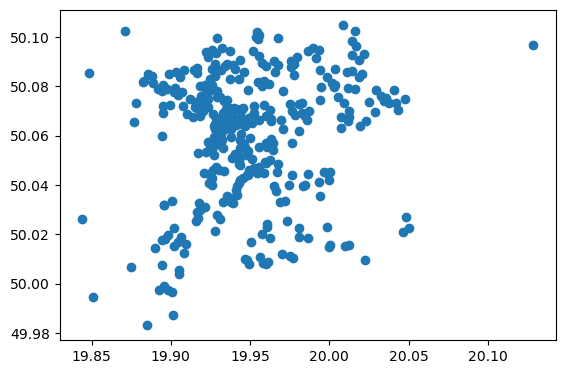

In [34]:
zabka_krakow.plot()

Let's save our geodatframe to a geoJSON file : 

In [47]:
# Specify the output file path and name
output_file = 'zabka_kraków.geojson'

# Save the GeoDataFrame as a GeoJSON file
zabka_krakow.to_file(output_file, driver='GeoJSON')

#### Żabka locations - Poznań

We simply repeat the process for Poznań : 

In [36]:
city = 'Poznań'

In [37]:
poznan_gdf = ox.geocode_to_gdf(city)
poznan_gdf

geometry  bbox_north  bbox_south  \
0  POLYGON ((16.73159 52.46375, 16.73162 52.46365...   52.509328   52.291924   

   bbox_east  bbox_west   place_id  osm_type   osm_id        lat       lon  \
0  17.071707  16.731588  187624076  relation  2456294  52.408266  16.93352   

      class            type  place_rank  importance addresstype    name  \
0  boundary  administrative          12    0.664541        city  Poznań   

                                 display_name  
0  Poznań, Greater Poland Voivodeship, Poland

In [38]:
shops_poznan = ox.geometries_from_place(
    city,
    tags ={'shop': True}    
)

/tmp/ipykernel_552/1581214074.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  shops_poznan = ox.geometries_from_place(


In [39]:
len(shops_poznan)

3671

In [40]:
zabka_poznan= shops_poznan.query("name == 'Żabka'")
zabka_poznan

amenity  brand fuel:diesel fuel:lpg fuel:octane_95  \
element_type osmid                                                          
node         430724948     NaN  Żabka         NaN      NaN            NaN   
             430999602     NaN  Żabka         NaN      NaN            NaN   
             431337246     NaN  Żabka         NaN      NaN            NaN   
             431337328     NaN  Żabka         NaN      NaN            NaN   
             431913532     NaN  Żabka         NaN      NaN            NaN   
...                        ...    ...         ...      ...            ...   
way          484409230     NaN    NaN         NaN      NaN            NaN   
             491283918     NaN  Żabka         NaN      NaN            NaN   
             492281557     NaN    NaN         NaN      NaN            NaN   
             576088500     NaN  Żabka         NaN      NaN            NaN   
             607697313     NaN  Żabka         NaN      NaN            NaN   

                       fuel:octane_98   name  \
element_type osmid                             
node         430724948            NaN  Żabka   
             430999602            NaN  Żabka   
             431337246            NaN  Żabka   
             431337328            NaN  Żabka   
             431913532            NaN  Żabka   
...                               ...    ...   
way          484409230            NaN  Żabka   
             491283918            NaN  Żabka   
             492281557            NaN  Żabka   
             576088500            NaN  Żabka   
             607697313            NaN  Żabka   

                                            opening_hours  \
element_type osmid                                          
node         430724948                                NaN   
             430999602                  Mo-Su 06:00-23:00   
             431337246                  Mo-Su 06:00-23:00   
             431337328                  Mo-Su 06:00-23:00   
             431913532                  Mo-Su 06:00-23:00   
...                                                   ...   
way          484409230  Mo-Sa 06:00-23:00; Su 11:00-20:00   
             491283918                  Mo-Su 06:00-23:00   
             492281557                                NaN   
             576088500                  Mo-Su 06:00-23:00   
             607697313                  Mo-Su 06:00-23:00   

                       payment:credit_cards payment:dkv  ... fuel:firewood  \
element_type osmid                                       ...                 
node         430724948                  NaN         NaN  ...           NaN   
             430999602                  NaN         NaN  ...           NaN   
             431337246                  NaN         NaN  ...           NaN   
             431337328                  NaN         NaN  ...           NaN   
             431913532                  NaN         NaN  ...           NaN   
...                                     ...         ...  ...           ...   
way          484409230                  NaN         NaN  ...           NaN   
             491283918                  NaN         NaN  ...           NaN   
             492281557                  NaN         NaN  ...           NaN   
             576088500                  NaN         NaN  ...           NaN   
             607697313                  NaN         NaN  ...           NaN   

                       service:vehicle:oil service:vehicle:geometry  \
element_type osmid                                                    
node         430724948                 NaN                      NaN   
             430999602                 NaN                      NaN   
             431337246                 NaN                      NaN   
             431337328                 NaN                      NaN   
             431913532                 NaN                      NaN   
...                                    ...                      ...   
way          484409

In [41]:
zabka_poznan = zabka_poznan.reset_index()
zabka_poznan

element_type      osmid amenity  brand fuel:diesel fuel:lpg  \
0           node  430724948     NaN  Żabka         NaN      NaN   
1           node  430999602     NaN  Żabka         NaN      NaN   
2           node  431337246     NaN  Żabka         NaN      NaN   
3           node  431337328     NaN  Żabka         NaN      NaN   
4           node  431913532     NaN  Żabka         NaN      NaN   
..           ...        ...     ...    ...         ...      ...   
240          way  484409230     NaN    NaN         NaN      NaN   
241          way  491283918     NaN  Żabka         NaN      NaN   
242          way  492281557     NaN    NaN         NaN      NaN   
243          way  576088500     NaN  Żabka         NaN      NaN   
244          way  607697313     NaN  Żabka         NaN      NaN   

    fuel:octane_95 fuel:octane_98   name                      opening_hours  \
0              NaN            NaN  Żabka                                NaN   
1              NaN            NaN  Żabka                  Mo-Su 06:00-23:00   
2              NaN            NaN  Żabka                  Mo-Su 06:00-23:00   
3              NaN            NaN  Żabka                  Mo-Su 06:00-23:00   
4              NaN            NaN  Żabka                  Mo-Su 06:00-23:00   
..             ...            ...    ...                                ...   
240            NaN            NaN  Żabka  Mo-Sa 06:00-23:00; Su 11:00-20:00   
241            NaN            NaN  Żabka                  Mo-Su 06:00-23:00   
242            NaN            NaN  Żabka                                NaN   
243            NaN            NaN  Żabka                  Mo-Su 06:00-23:00   
244            NaN            NaN  Żabka                  Mo-Su 06:00-23:00   

     ... fuel:firewood service:vehicle:oil service:vehicle:geometry  \
0    ...           NaN                 NaN                      NaN   
1    ...           NaN                 NaN                      NaN   
2    ...           NaN                 NaN                      NaN   
3    ...           NaN                 NaN                      NaN   
4    ...           NaN                 NaN                      NaN   
..   ...           ...                 ...                      ...   
240  ...           NaN                 NaN                      NaN   
241  ...           NaN                 NaN                      NaN   
242  ...           NaN                 NaN                      NaN   
243  ...           NaN                 NaN                      NaN   
244  ...           NaN                 NaN                      NaN   

    service:vehicle:glass service:vehicle:suspension construction:start_date  \
0                     NaN                        NaN                     NaN   
1                     NaN                        NaN                     NaN   
2                     NaN                        NaN                     NaN   
3                     NaN                        NaN                     NaN   
4                     NaN                        NaN                     NaN   
..                    ...                        ...                     ...   
240                   NaN                        NaN                     NaN   
241                   NaN                        NaN                     NaN   
242                   NaN                        NaN                     NaN   
243                   NaN                        NaN                     NaN   
244                   NaN                        NaN                     NaN   

    level_name service:vehicle:electrical ways type  
0          NaN                        NaN  NaN  NaN  
1          NaN                        NaN  NaN  NaN  
2          NaN                        NaN  NaN  NaN  
3          NaN                        NaN  NaN  NaN  
4          NaN                        NaN  NaN  NaN  
..         ...                        ...  ...  ...  
240        NaN                        NaN  NaN  NaN  
241 

In [42]:
zabka_poznan = zabka_poznan.query("element_type== 'node'")
zabka_poznan

element_type        osmid amenity  brand fuel:diesel fuel:lpg  \
0           node    430724948     NaN  Żabka         NaN      NaN   
1           node    430999602     NaN  Żabka         NaN      NaN   
2           node    431337246     NaN  Żabka         NaN      NaN   
3           node    431337328     NaN  Żabka         NaN      NaN   
4           node    431913532     NaN  Żabka         NaN      NaN   
..           ...          ...     ...    ...         ...      ...   
218         node  11083648150     NaN  Żabka         NaN      NaN   
219         node  11083648169     NaN  Żabka         NaN      NaN   
220         node  11142130284     NaN  Żabka         NaN      NaN   
221         node  11162808761     NaN  Żabka         NaN      NaN   
222         node  11298486566     NaN  Żabka         NaN      NaN   

    fuel:octane_95 fuel:octane_98   name  \
0              NaN            NaN  Żabka   
1              NaN            NaN  Żabka   
2              NaN            NaN  Żabka   
3              NaN            NaN  Żabka   
4              NaN            NaN  Żabka   
..             ...            ...    ...   
218            NaN            NaN  Żabka   
219            NaN            NaN  Żabka   
220            NaN            NaN  Żabka   
221            NaN            NaN  Żabka   
222            NaN            NaN  Żabka   

                                 opening_hours  ... fuel:firewood  \
0                                          NaN  ...           NaN   
1                            Mo-Su 06:00-23:00  ...           NaN   
2                            Mo-Su 06:00-23:00  ...           NaN   
3                            Mo-Su 06:00-23:00  ...           NaN   
4                            Mo-Su 06:00-23:00  ...           NaN   
..                                         ...  ...           ...   
218                                        NaN  ...           NaN   
219                                        NaN  ...           NaN   
220                                        NaN  ...           NaN   
221                                        NaN  ...           NaN   
222  Mo-Sa 06:00-23:00; Su 08:00-22:00; PH off  ...           NaN   

    service:vehicle:oil service:vehicle:geometry service:vehicle:glass  \
0                   NaN                      NaN                   NaN   
1                   NaN                      NaN                   NaN   
2                   NaN                      NaN                   NaN   
3                   NaN                      NaN                   NaN   
4                   NaN                      NaN                   NaN   
..                  ...                      ...                   ...   
218                 NaN                      NaN                   NaN   
219                 NaN                      NaN                   NaN   
220                 NaN                      NaN                   NaN   
221                 NaN                      NaN                   NaN   
222                 NaN                      NaN                   NaN   

    service:vehicle:suspension construction:start_date level_name  \
0                          NaN                     NaN        NaN   
1                          NaN                     NaN        NaN   
2                          NaN                     NaN        NaN   
3                          NaN                     NaN        NaN   
4                          NaN                     NaN        NaN   
..                         ...                     ...        ...   
218                        NaN                     NaN        NaN   
219                        NaN                     NaN        NaN   
220                        NaN                     NaN        NaN   
221                        NaN                     NaN        NaN   
222                        NaN                     NaN        NaN   

    service:vehicle:electrical ways type  
0                          NaN  NaN  NaN  
1            

So we have fewer stores in Poznań - 223 against 347 in Kraków - which is not surprising given the comparative populations of the two cities.

<AxesSubplot: >

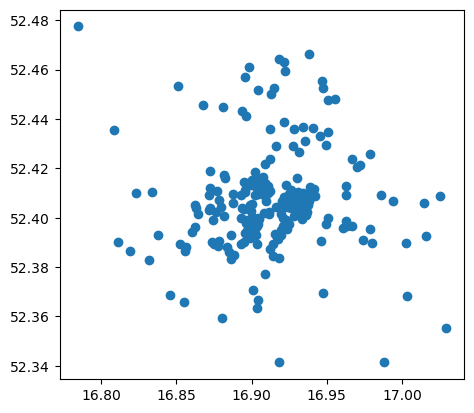

In [43]:
zabka_poznan.plot()

In [44]:
type(zabka_poznan)

geopandas.geodataframe.GeoDataFrame

Save the file once again to GeoJSON format:

In [48]:
# Specify the output file path and name
output_file = 'zabka_poznań.geojson'

# Save the GeoDataFrame as a GeoJSON file
zabka_poznan.to_file(output_file, driver='GeoJSON')

Let's visualise the distribution of stores in each city side by side: 

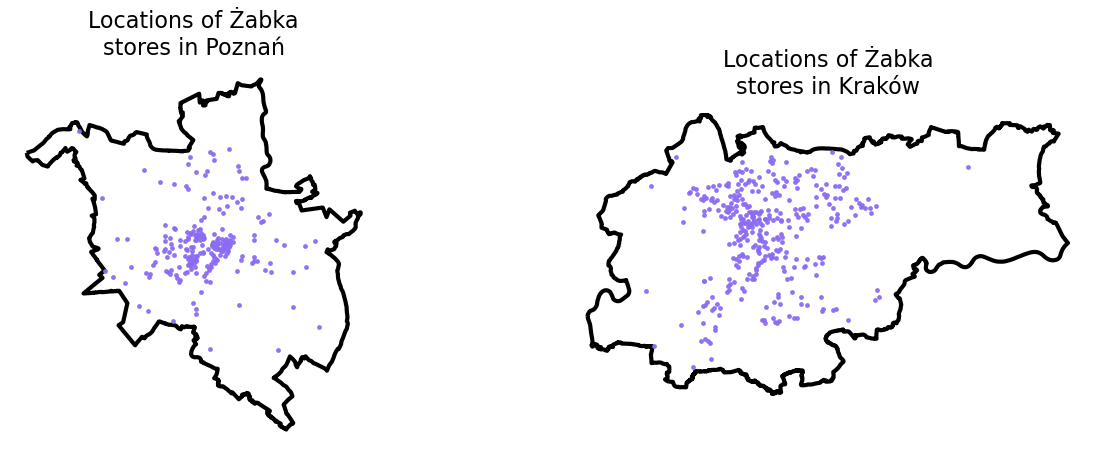

In [50]:
# parse the data for each city
gdf_units= {}

gdf_units['Kraków'] = gpd.read_file('zabka_kraków.geojson')
gdf_units['Poznań'] = gpd.read_file('zabka_poznań.geojson')

for city in cities:
    gdf_units[city] = gpd.overlay(gdf_units[city], admin[city])


# visualize the units
f, ax = plt.subplots(1,2, figsize = (15,5))

for idx, city in enumerate(cities):
    admin[city].plot(ax=ax[idx],color='none',edgecolor= 'k', linewidth = 3)
    gdf_units[city].plot( ax=ax[idx], alpha = 0.9, color = very_peri, \
      markersize = 6.0)
    ax[idx].set_title('Locations of Żabka\nstores in ' + city, \
      fontsize = 16)
    ax[idx].axis('off')

## 2. Accessibilty computation

Referencing [this great article](https://towardsdatascience.com/measuring-pedestrian-accessibility-97900f9e4d56) written by Nick Jones in 2018 on how to compute pedestrian accessibility:

In [51]:
import os
!pip install pandana
!pip install osmnet
import pandana # version: 0.6
import pandas as pd # version: 1.4.2
import numpy as np # version: 1.22.4
from shapely.geometry import Point # version:  1.7.1
from pandana.loaders import osm

def get_city_accessibility(admin, POIs):

    # walkability parameters
    walkingspeed_kmh = 5 # est mean walking speed
    walkingspeed_mm  = walkingspeed_kmh * 1000 / 60
    distance = 1609 # metres (1 mile)


    # bounding box as a list of llcrnrlat, llcrnrlng, urcrnrlat, urcrnrlng
    minx, miny, maxx, maxy = admin.bounds.T[0].to_list()
    bbox = [miny, minx, maxy, maxx]

    # setting the input params, going for the nearest POI
    num_pois = 1
    num_categories = 1
    bbox_string = '_'.join([str(x) for x in bbox])
    net_filename = 'data/network_{}.h5'.format(bbox_string)
    if not os.path.exists('data'): os.makedirs('data')

    # precomputing nework distances
    
    if os.path.isfile(net_filename):
        # if a street network file already exists, just load the dataset from that
        network = pandana.network.Network.from_hdf5(net_filename)
        method = 'loaded from HDF5'
    else:
        # otherwise, query the OSM API for the street network within the specified bounding box
        network = osm.pdna_network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
        method = 'downloaded from OSM'

        # identify nodes that are connected to fewer than some threshold of other nodes within a given distance
        lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')
        network.save_hdf5(net_filename, rm_nodes=lcn) #remove low-connectivity nodes and save to h5


    # precomputes the range queries (the reachable nodes within this maximum distance)
    # so, as long as you use a smaller distance, cached results will be used
    network.precompute(distance + 1)
    
    
    # compute accessibilities on POIs
    pois = POIs.copy()
    pois['lon'] = pois.geometry.apply(lambda g: g.x)
    pois['lat'] = pois.geometry.apply(lambda g: g.y)
    pois = pois.drop(columns = ['geometry'])
    network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)
    
    network.set_pois(category='all', x_col=pois['lon'], y_col=pois['lat'])

    # searches for the n nearest amenities (of all types) to each node in the network
    all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

    # transform the results into a geodataframe
    nodes = network.nodes_df
    nodes_acc = nodes.merge(all_access[[1]], left_index = True, right_index = True).rename(columns = {1 : 'distance'})
    nodes_acc['time'] = nodes_acc.distance / walkingspeed_mm
    xs = list(nodes_acc.x)
    ys = list(nodes_acc.y)
    nodes_acc['geometry'] = [Point(xs[i], ys[i]) for i in range(len(xs))]
    nodes_acc = gpd.GeoDataFrame(nodes_acc)
    nodes_acc = gpd.overlay(nodes_acc, admin)
    
    nodes_acc[['time', 'geometry']].to_file(city + '_accessibility.geojson', driver = 'GeoJSON')
    
    return nodes_acc[['time', 'geometry']]


accessibilities = {}
for city in cities:
    accessibilities[city] = get_city_accessibility(admin[city], gdf_units[city])

DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'; python_version >= "3.6". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'; python_version >= "3.6". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 140785
Setting CH edge vector of size 301261
Range graph removed 200700 edges of 602522
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80%

/home/stephen137/mambaforge/lib/python3.10/site-packages/pandana/network.py:705: DeprecationWarning: Method init_pois() is no longer needed in Pandana 0.4+ and will be removed in a             future version; maxdist and maxitems should now be passed to set_pois()
  warnings.warn(


Reading parameters from init_pois()
Reading parameters from init_pois()


/tmp/ipykernel_552/2843922756.py:70: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  nodes_acc = gpd.overlay(nodes_acc, admin)


Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 160669
Setting CH edge vector of size 234071
Range graph removed 37970 edges of 468142
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


/home/stephen137/mambaforge/lib/python3.10/site-packages/pandana/network.py:705: DeprecationWarning: Method init_pois() is no longer needed in Pandana 0.4+ and will be removed in a             future version; maxdist and maxitems should now be passed to set_pois()
  warnings.warn(


Reading parameters from init_pois()
Reading parameters from init_pois()


/tmp/ipykernel_552/2843922756.py:70: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  nodes_acc = gpd.overlay(nodes_acc, admin)


This code block outputs the number of road network nodes in Poznań (105,157) and in Kraków (128,495).

In [52]:
for city in cities:
    print('Number of road network nodes in ' + \
      city + ': ' + str(len(accessibilities[city])))

Number of road network nodes in Poznań: 105157
Number of road network nodes in Kraków: 128495


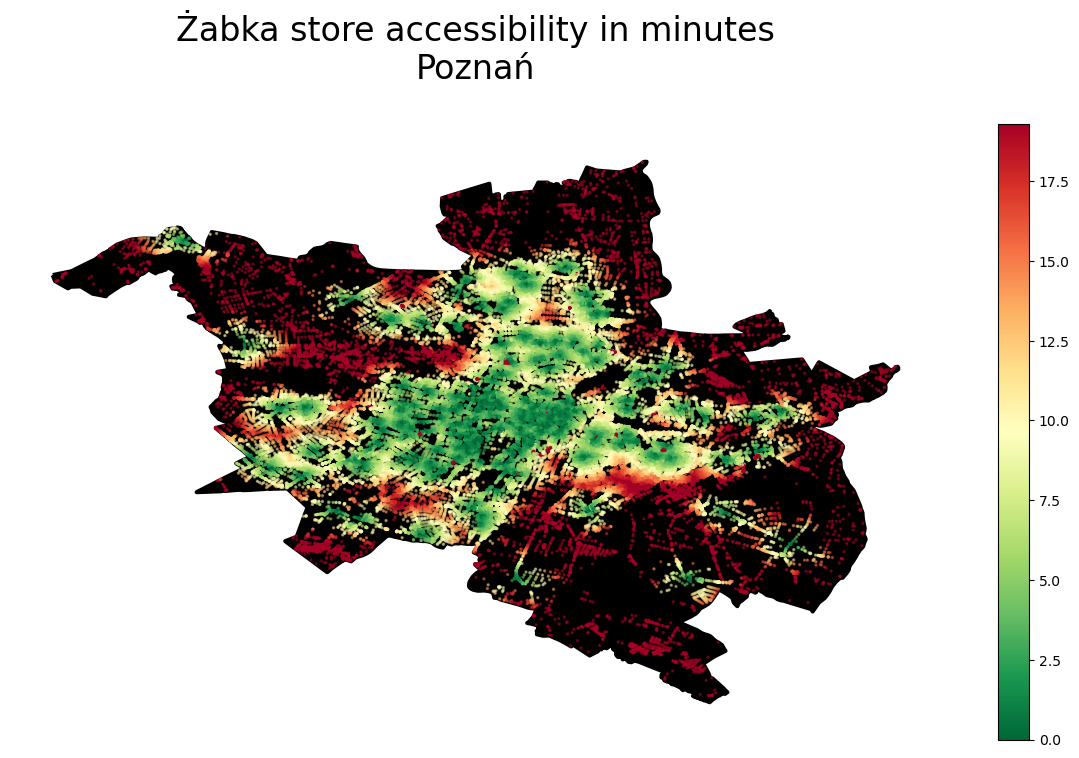

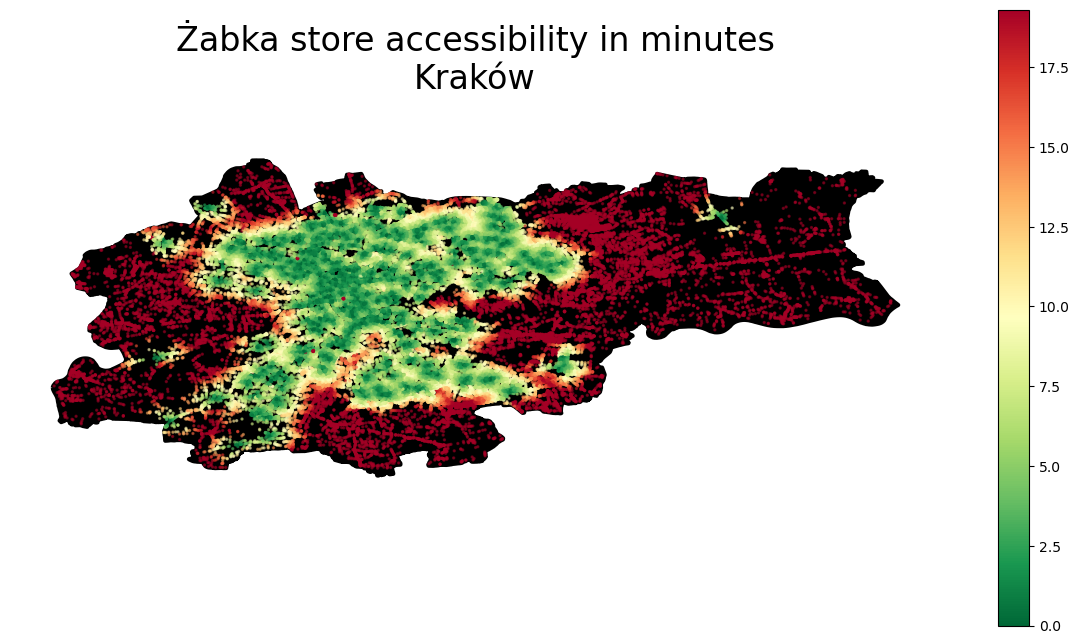

In [53]:
for city in cities:
    f, ax = plt.subplots(1,1,figsize=(15,8))
    admin[city].plot(ax=ax, color = 'k', edgecolor = 'k', linewidth = 3)
    accessibilities[city].plot(column = 'time', cmap = 'RdYlGn_r', \
      legend = True,  ax = ax, markersize = 2, alpha = 0.5)
    ax.set_title('Żabka store accessibility in minutes\n' + city, \
      pad = 40, fontsize = 24)    
    ax.axis('off')

## 3. Mapping to H3 grid cells

At this point, we have both the population and the accessibility data; we just have to bring them together. The only trick is that their spatial units differ:

- Accessibility is measured and attached to each node within the road network of each city
- Population data is derived from a raster grid, now described by the POI of each raster grid’s centroid

While rehabilitating the original raster grid may be an option, in the hope of a more pronounced universality let's map these two types of point data sets into the [H3 grid system of Uber](https://www.uber.com/en-HU/blog/h3/). For those who haven’t used it before, for now, its enough to know that it’s an elegant, efficient spacial indexing system using hexagon tiles.

### 3.1. Creating H3 cells

First, put together a function that splits a city into hexagons at any given resolution:

<AxesSubplot: >

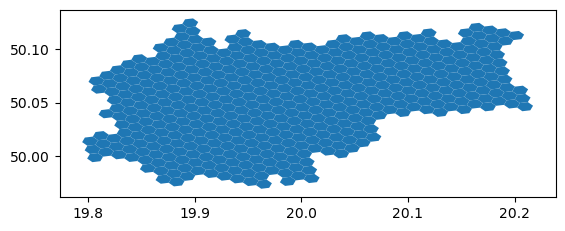

In [54]:
import geopandas as gpd
import h3 # version: 3.7.3
from shapely.geometry import Polygon # version: 1.7.1
import numpy as np

def split_admin_boundary_to_hexagons(admin_gdf, resolution):
    coords = list(admin_gdf.geometry.to_list()[0].exterior.coords)
    admin_geojson = {"type": "Polygon",  "coordinates": [coords]}
    hexagons = h3.polyfill(admin_geojson, resolution, \
      geo_json_conformant=True)
    hexagon_geometries = {hex_id : Polygon(h3.h3_to_geo_boundary(hex_id, \
      geo_json=True)) for hex_id in hexagons}
    return gpd.GeoDataFrame(hexagon_geometries.items(), columns = ['hex_id', 'geometry'])


resolution = 8  
hexagons_gdf = split_admin_boundary_to_hexagons(admin[city], resolution)
hexagons_gdf.plot()


Now, see a few different resolutions:

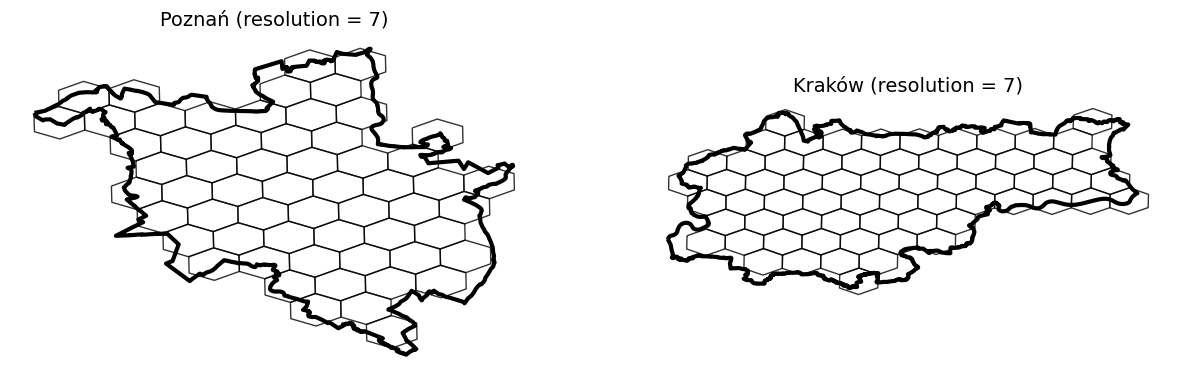

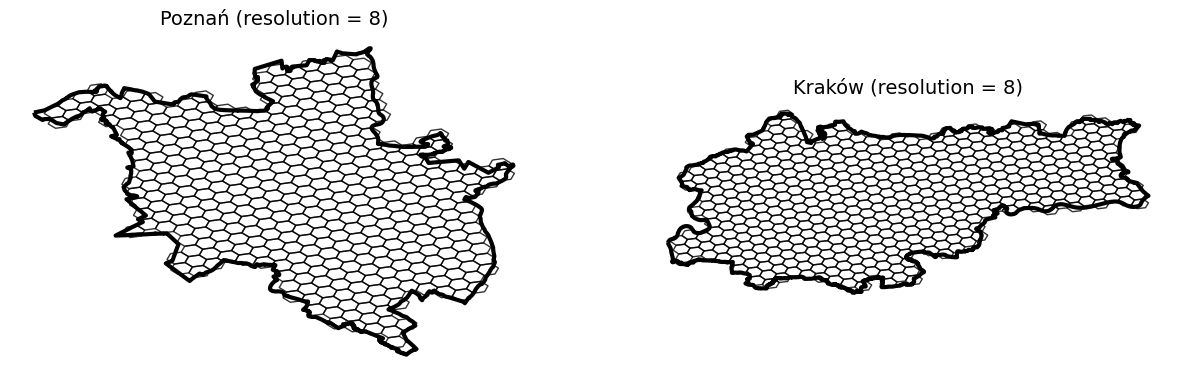

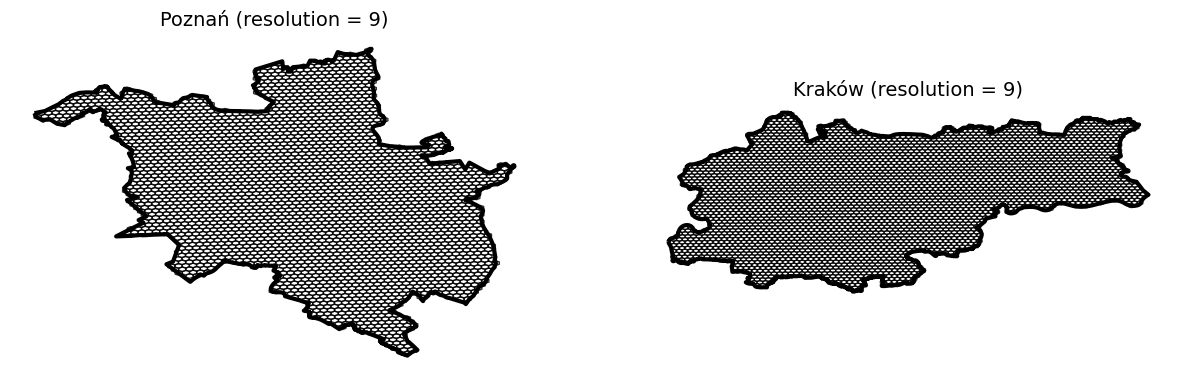

In [55]:
for resolution in [7,8,9]:
    
    admin_h3 = {}
    for city in cities:
        admin_h3[city] = split_admin_boundary_to_hexagons(admin[city], resolution)

    f, ax = plt.subplots(1,2, figsize = (15,5))

    for idx, city in enumerate(cities):
        admin[city].plot(ax=ax[idx], color = 'none', edgecolor = 'k', \
          linewidth = 3)
        admin_h3[city].plot( ax=ax[idx], alpha = 0.8, edgecolor = 'k', \
           color = 'none')
        ax[idx].set_title(city + ' (resolution = '+str(resolution)+')', \
            fontsize = 14)
        ax[idx].axis('off')

Let's stick with resolution 9.

### 3.2. Map values into h3 cells

Now, we have both our cities in a hexagon grid format. Next, we shall map the population and accessibility data into the hexagon cells based on which grid cells each point geometry falls into. For this, the sjoin function of GeoPandasa, doing a nice spatial join, is a good choice.

Additionally, as we have more than 100k road network nodes in each city and thousands of population grid centroids, most likely, there will be multiple POIs mapped into each hexagon grid cell. Therefore, aggregation will be needed. As the population is an additive quantity, we will aggregate population levels within the same hexagon by summing them up. However, accessibility is not extensive, so I would instead compute the average store accessibility time for each tile.

/tmp/ipykernel_552/223882290.py:9: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  demographics_dict = gpd.sjoin(admin_h3[city], demographics[city]).groupby(by = 'hex_id').sum('population').to_dict()['population']
/tmp/ipykernel_552/223882290.py:9: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  demographics_dict = gpd.sjoin(admin_h3[city], demographics[city]).groupby(by = 'hex_id').sum('population').to_dict()['population']


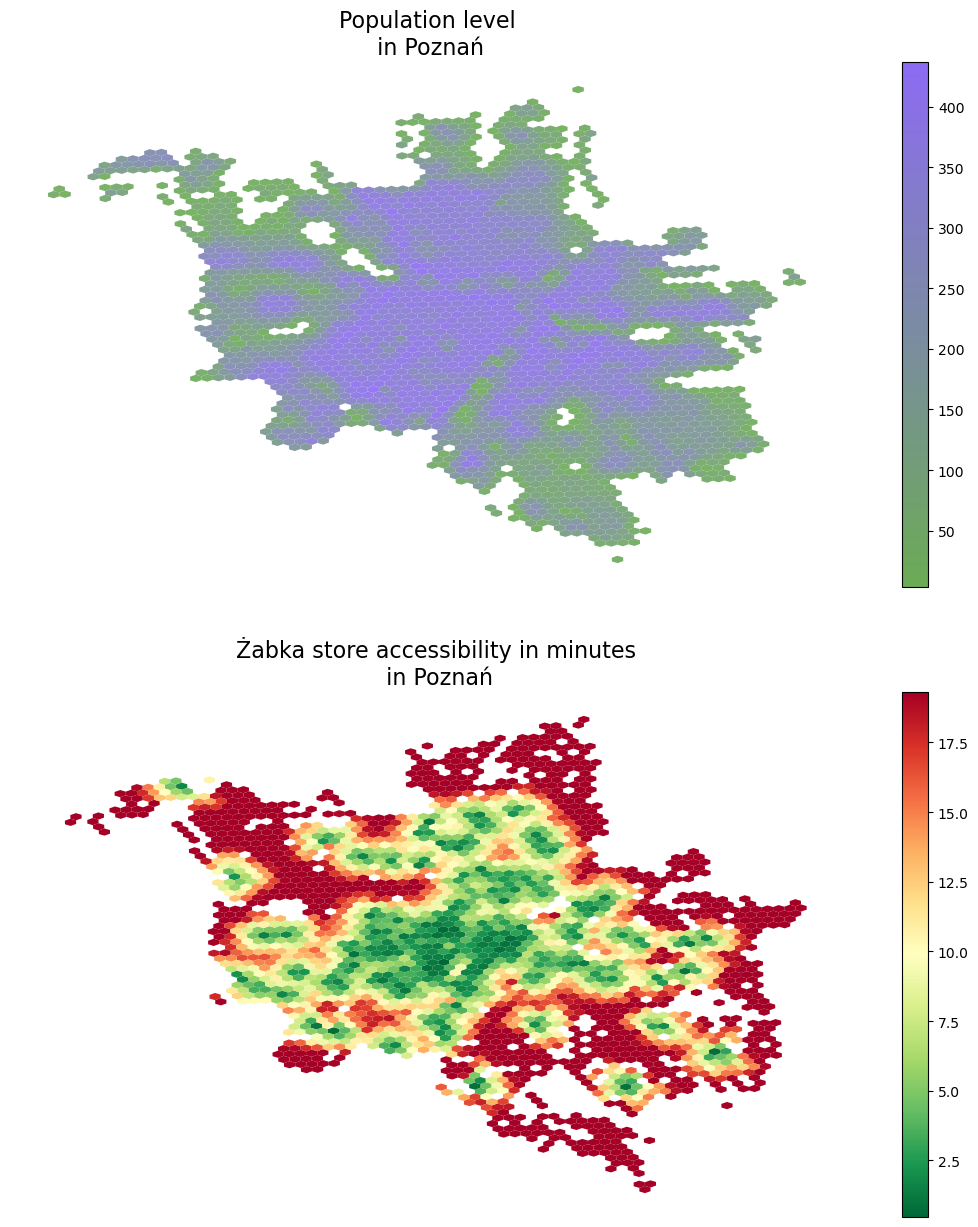

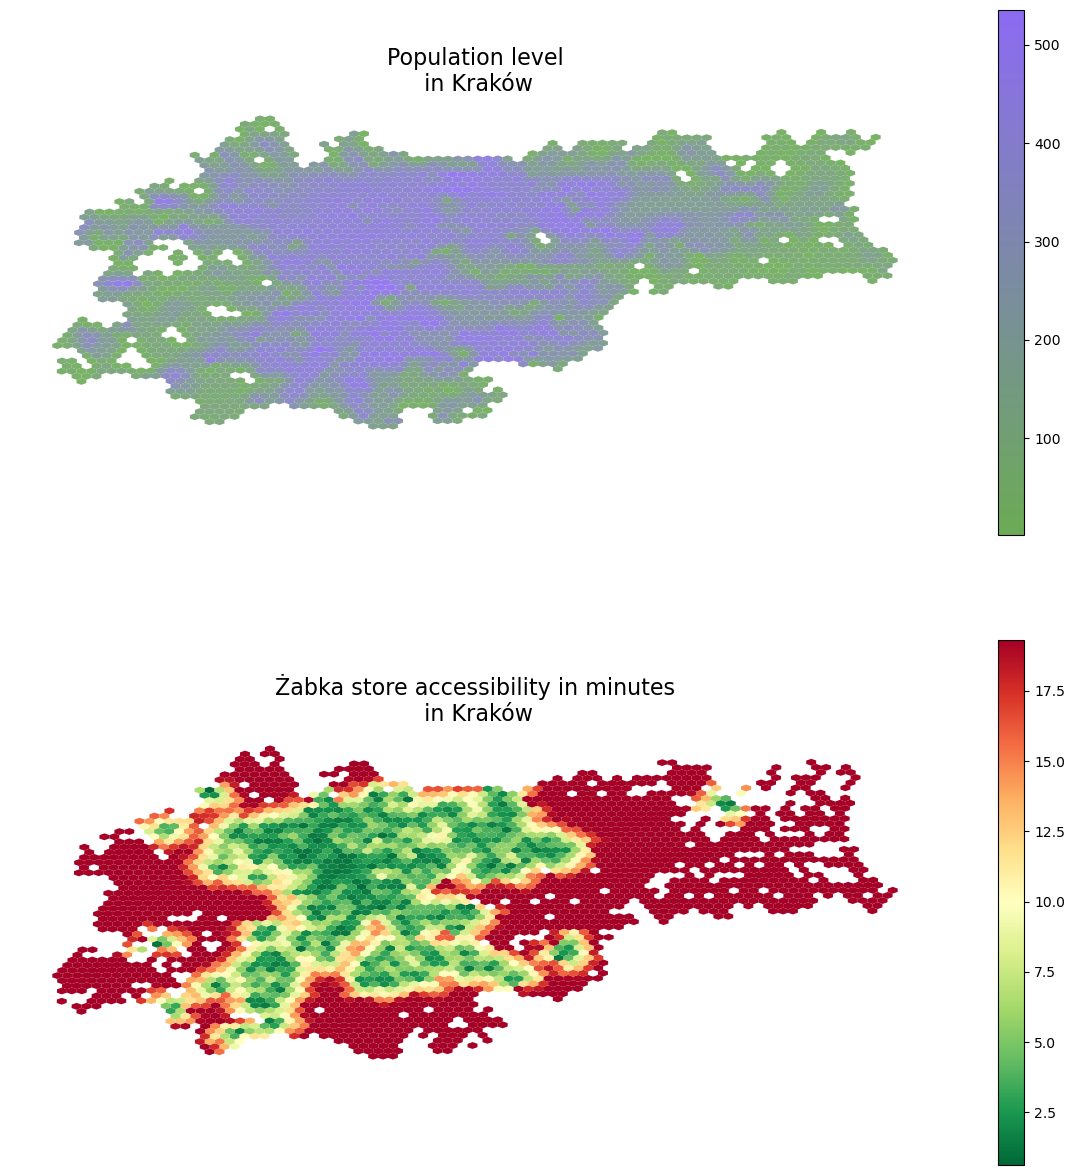

In [56]:
demographics_h3 = {}
accessibility_h3 = {}


for city in cities:

    # do the spatial join, aggregate on the population level of each \
    # hexagon, and then map these population values to the grid ids
    demographics_dict = gpd.sjoin(admin_h3[city], demographics[city]).groupby(by = 'hex_id').sum('population').to_dict()['population']
    demographics_h3[city] = admin_h3[city].copy()
    demographics_h3[city]['population'] = demographics_h3[city].hex_id.map(demographics_dict)

    # do the spatial join, aggregate on the population level by averaging 
    # accessiblity times within each hexagon, and then map these time score  #  to the grid ids
    accessibility_dict = gpd.sjoin(admin_h3[city], accessibilities[city]).groupby(by = 'hex_id').mean('time').to_dict()['time']
    accessibility_h3[city]   = admin_h3[city].copy()
    accessibility_h3[city]['time'] = \
      accessibility_h3[city].hex_id.map(accessibility_dict)

    
    # now show the results
    f, ax = plt.subplots(2,1,figsize = (15,15))

    demographics_h3[city].plot(column = 'population', legend = True, \
      cmap = colormap, ax=ax[0], alpha = 0.9, markersize = 0.25)
    accessibility_h3[city].plot(column = 'time', cmap = 'RdYlGn_r', \
      legend = True,  ax = ax[1])

    ax[0].set_title('Population level\n in ' + city, fontsize = 16)
    ax[1].set_title('Żabka store accessibility in minutes\n in ' + city, \
      fontsize = 16)

    for ax_i in ax: ax_i.axis('off')

## 4. Computing population reach

In this final step, we will estimate the fraction of the reachable population from the nearest Żabka store within a certain amount of time. Here, I still build on the relatively fast 15km/h running pace and the 2.5km distance limit.

From the technical perspective, I merge the H3-level population and accessibility time data frames and then do a simple thresholding on the time dimension and a sum on the population dimension.

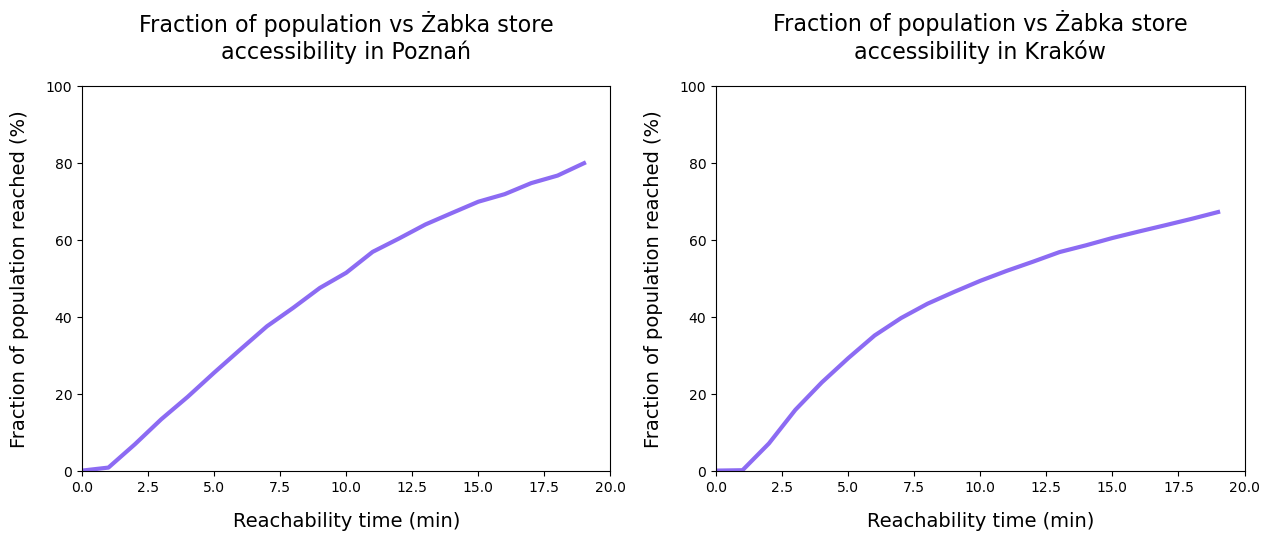

In [60]:
f, ax = plt.subplots(1,2, figsize = (15,5))

for idx, city in enumerate(cities):

    total_pop  = demographics_h3[city].population.sum()
    merged = demographics_h3[city].merge(accessibility_h3[city].drop(columns =\
     ['geometry']), left_on = 'hex_id', right_on = 'hex_id')

    time_thresholds = range(20)
    population_reached = [100*merged[merged.time<limit].population.sum()/total_pop for limit in time_thresholds]

    ax[idx].plot(time_thresholds, population_reached, linewidth = 3, \
      color = very_peri)
    ax[idx].set_xlabel('Reachability time (min)', fontsize = 14, \
      labelpad = 12)
    ax[idx].set_ylabel('Fraction of population reached (%)', fontsize = 14, labelpad = 12)
    ax[idx].set_xlim([0,20])
    ax[idx].set_ylim([0,100])
    ax[idx].set_title('Fraction of population vs Żabka store\naccessibility in ' + city, pad = 20, fontsize = 16)


## 5. Conclusion

When interpreting these results, I would like to emphasize that the store information obtained from Open Street Maps may not be a comprehensive listing of all Żabka stores.

After this disclaimer, what do we see? On the one hand, we see that in both cities, roughly half of the population can get to a store within a 10 minute walk. Extending walking time to 20 minutes results in around 80% access in Poznań, and around 70% access achived in Kraków. 

Note that in addition to the caveat of incomplete data, it is important to remember that store accessibility has been calculated based on a walking speed of 5km per hour. This may not be representative of average walking speeds within the cities.

Notwithstanding these reservations, this study provides a solid methodology for combining population data with urban amenity data, to quantify accessibilty. This study can be extended to different cities and amenities across the globe, and the framework is scaleable to different levels of granularity using Uber's innovative H3 grid system.
